In [1]:
import numpy as np

## 定义了一个BP神经网络类：BP_Net

In [2]:
class BP_Net(object):
    '''
        BP神经网络类
    '''
    #初始函数
    def __init__(self, input_nodes, hidden_nodes, output_nodes, lr):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        #权重初始化 Xavier的正态分布方法
        self.W_ih = np.random.normal(loc=0.0, scale=np.sqrt(2/(input_nodes+hidden_nodes)), size=(hidden_nodes, input_nodes))
        self.b_ih = np.random.normal(loc=0.0, scale=np.sqrt(2/(input_nodes+hidden_nodes)), size=(hidden_nodes, 1))
        self.W_ho = np.random.normal(loc=0.0, scale=np.sqrt(2/(output_nodes+hidden_nodes)), size=(output_nodes, hidden_nodes))
        self.b_ho = np.random.normal(loc=0.0, scale=np.sqrt(2/(input_nodes+hidden_nodes)), size=(output_nodes, 1))
        #学习率
        self.lr = lr
    
    #激活函数
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    #前向传播
    def forword_p(self, input_one):
        inputs = self.convert2column(input_one)
        #前向传播
        hidden_outputs = self.sigmoid(np.dot(self.W_ih, inputs))
        final_outputs = self.sigmoid(np.dot(self.W_ho, hidden_outputs))
        return hidden_outputs, final_outputs
    
    #预测
    def predict(self, input_data):
        inputs = np.array(input_data)
        prediction = []
        for i in range(inputs.shape[0]):
            #转为列向量
            inputs_one = self.convert2column(inputs[i,:])
            #前向传播
            _, final_outputs = self.forword_p(inputs_one)
            final_outputs = self.convert2column(final_outputs)
            prediction.append(final_outputs)
        return prediction
    
    #准确率
    def score(self, input_data, gt_data):
        prediction = self.predict(input_data)
        for j in range(len(prediction)):
            prediction[j] = np.argmax(prediction[j])
        count = 0
        for i in range(gt_data.shape[0]):
            if prediction[i] == gt_data[i]:
                count += 1
        return count/gt_data.shape[0]
    
    #loss函数
    def loss_func(self, input_data, gt_data):
        inputs = np.array(input_data)
        gt = np.array(gt_data)
        loss = 0
        prediction = self.predict(input_data)
        for i in range(gt_data.shape[0]):
            gt_one = self.convert2column(gt[i,:])
            loss += np.sum(0.5* (prediction[i]- gt_one)**2)
        return loss/gt_data.shape[0]
    
    #把向量转为列向量
    def convert2column(self, x):
        c = np.array(x, ndmin=2)
        if c.shape[0] == 1:
            c = c.T
        return c
    
    #BP
    def b_p(self, input_data, gt_data):
        '''
        Parameters:
            input_data: 样本特征，按行保存的数据
            gt_data: 样本类别，按行保存
        Return:
            
        '''
        inputs = np.array(input_data)
        gt = np.array(gt_data)
        delta_W_ho = []
        delta_b_ho = []
        delta_W_ih = []
        delta_b_ih = []
        for i in range(inputs.shape[0]):
            #转为列向量
            inputs_one = self.convert2column(inputs[i,:])
            gt_one = self.convert2column(gt[i,:])
            #前向传播
            hidden_outputs, final_outputs = self.forword_p(inputs_one)
            hidden_outputs = self.convert2column(hidden_outputs)
            final_outputs = self.convert2column(final_outputs)
            #反向传播梯度
            final_errors = final_outputs - gt_one   # 1/2(y-a)^2 关于a的导数
            delta_f = final_errors* final_outputs* (1-final_outputs)
            delta_h = np.dot(self.W_ho.T, delta_f) * hidden_outputs* (1-hidden_outputs)

            delta_W_ho.append(np.dot(delta_f, hidden_outputs.T))
            delta_b_ho.append(delta_f)
            delta_W_ih.append(np.dot(delta_h, inputs_one.T))
            delta_b_ih.append(delta_h)
        #求平均
        delta_W_ho_result = delta_W_ho[0]
        delta_b_ho_result = delta_b_ho[0]
        delta_W_ih_result = delta_W_ih[0]
        delta_b_ih_result = delta_b_ih[0]
        for j in range(1, len(delta_W_ho)):
            delta_W_ho_result += delta_W_ho[j]
            delta_b_ho_result += delta_b_ho[j]
            delta_W_ih_result += delta_W_ih[j]
            delta_b_ih_result += delta_b_ih[j]
        delta_W_ho_result /= len(delta_W_ho)
        delta_b_ho_result /= len(delta_W_ho)
        delta_W_ih_result /= len(delta_W_ho)
        delta_b_ih_result /= len(delta_W_ho)
        #权值更新
        self.W_ho += self.lr* -1* delta_W_ho_result
        self.b_ho += self.lr* -1* delta_b_ho_result
        self.W_ih += self.lr* -1* delta_W_ih_result
        self.b_ih += self.lr* -1* delta_b_ih_result
    
    #训练
    def train(self, input_data, gt_data, iteration):
        for i in range(iteration):
            self.b_p(input_data, gt_data)
            if self.loss_func(input_data, gt_data) < 1e-5:
                break
        

## 导入数据集

In [3]:
from sklearn import datasets

digits = datasets.load_digits()
mnist_data = digits.data
mnist_label = digits.target

In [4]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(mnist_data, mnist_label, test_size=0.5)

In [5]:
#使用onehot编码类别
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
train_onehot = enc.fit_transform(np.array(train_label, ndmin=2).T)
train_onehot = train_onehot.toarray()

test_onehot = enc.transform(np.array(test_label, ndmin=2).T)
test_onehot = test_onehot.toarray()

## 创建NP_Net对象，训练和测试

In [6]:
bp1 = BP_Net(train_data.shape[1],20, train_onehot.shape[1], lr=1)

In [7]:
print('训练前训练集的损失：{}'.format(bp1.loss_func(train_data, train_onehot)))
print('训练前训练集的准确率： {}'.format(bp1.score(train_data, train_label)))
print('训练前测试集的损失：{}'.format(bp1.loss_func(test_data, test_onehot)))
print('训练前测试集的准确率： {}'.format(bp1.score(test_data, test_label)))
#训练
bp1.train(train_data, train_onehot, 200)
print('--------------------------------------------------------------')
print('训练后训练集的损失：{}'.format(bp1.loss_func(train_data, train_onehot)))
print('训练后训练集的准确率： {}'.format(bp1.score(train_data, train_label)))
print('训练后测试集的损失：{}'.format(bp1.loss_func(test_data, test_onehot)))
print('训练后测试集的准确率： {}'.format(bp1.score(test_data, test_label)))

训练前训练集的损失：1.5046376892463402
训练前训练集的准确率： 0.0801781737193764
训练前测试集的损失：1.5127138132471667
训练前测试集的准确率： 0.08342602892102335
--------------------------------------------------------------
训练后训练集的损失：0.18510479107096273
训练后训练集的准确率： 0.8596881959910914
训练后测试集的损失：0.20959857747424318
训练后测试集的准确率： 0.8053392658509455


### 再训练更多次数

In [8]:
bp1.train(train_data, train_onehot, 200)
print('训练后训练集的损失：{}'.format(bp1.loss_func(train_data, train_onehot)))
print('训练后训练集的准确率： {}'.format(bp1.score(train_data, train_label)))
print('训练后测试集的损失：{}'.format(bp1.loss_func(test_data, test_onehot)))
print('训练后测试集的准确率： {}'.format(bp1.score(test_data, test_label)))

训练后训练集的损失：0.10370692966757962
训练后训练集的准确率： 0.955456570155902
训练后测试集的损失：0.130545361838141
训练后测试集的准确率： 0.917686318131257


In [16]:
bp2 = BP_Net(train_data.shape[1],20, train_onehot.shape[1], lr=1)
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for i in range(250):
    bp2.train(train_data, train_onehot, 20)
    train_loss_once = bp2.loss_func(train_data, train_onehot)
    train_acc_once = bp2.score(train_data, train_label)
    test_loss_once = bp2.loss_func(test_data, test_onehot)
    test_acc_once = bp2.score(test_data, test_label)
    train_loss.append(train_loss_once)
    train_acc.append(train_acc_once)
    test_loss.append(test_loss_once)
    test_acc.append(test_acc_once)
    if i % 25 == 0:
        print('训练后训练集的损失：{}'.format(train_loss_once))
        print('训练后训练集的准确率： {}'.format(train_acc_once))
        print('训练后测试集的损失：{}'.format(test_loss_once))
        print('训练后测试集的准确率： {}'.format(test_acc_once))
        print('----------------------------------------------------')

训练后训练集的损失：0.424612677747868
训练后训练集的准确率： 0.321826280623608
训练后测试集的损失：0.42548376755647577
训练后测试集的准确率： 0.3170189098998888
----------------------------------------------------
训练后训练集的损失：0.04481131563556808
训练后训练集的准确率： 0.9832962138084632
训练后测试集的损失：0.066736352205287
训练后测试集的准确率： 0.9588431590656284
----------------------------------------------------
训练后训练集的损失：0.024120628742452195
训练后训练集的准确率： 0.9899777282850779
训练后测试集的损失：0.05170605697230012
训练后测试集的准确率： 0.9588431590656284
----------------------------------------------------
训练后训练集的损失：0.01735037367382791
训练后训练集的准确率： 0.9899777282850779
训练后测试集的损失：0.04764590054982109
训练后测试集的准确率： 0.9566184649610678
----------------------------------------------------
训练后训练集的损失：0.014110268723153654
训练后训练集的准确率： 0.9899777282850779
训练后测试集的损失：0.04573695203726829
训练后测试集的准确率： 0.9566184649610678
----------------------------------------------------
训练后训练集的损失：0.01194395879932072
训练后训练集的准确率： 0.9922048997772829
训练后测试集的损失：0.04438354261717707
训练后测试集的准确率： 0.9577308120133482
------

### 损失和准确率变化趋势

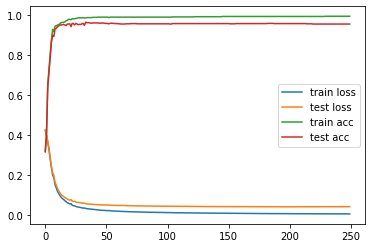

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend(loc='best')
plt.show()